In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import math


### INSTANCE

In [2]:
INSTANCE = 'LR1_1_DR1_3_VC1_V7a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V8a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V9a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V11a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V12a'
# INSTANCE = 'LR1_2_DR1_3_VC2_V6a'

# INSTANCE = 'LR1_1_DR1_4_VC3_V12b'
# INSTANCE = 'LR1_2_DR1_3_VC3_V8a'
# INSTANCE = 'LR2_11_DR2_22_VC3_V6a'
# INSTANCE = 'LR2_11_DR2_33_VC4_V11a'

INSTANCE_PATH = INSTANCE+'/'+INSTANCE+'.txt'
VESSELINFO_PATH = INSTANCE+'/vessel_data.txt'

### LOGGING

In [3]:
# LOG = True
LOG = False

# FA = True
FA = False

# if FA:
#     FILEPATH = f'new_official_solutions/{INSTANCE}/MIRP_RF_SPEED_OPTI_results_{INSTANCE}_45_FA.txt'
# else:
#     FILEPATH = f'new_official_solutions/{INSTANCE}/MIRP_RF_SPEED_OPTI_results_{INSTANCE}_45_NA.txt'

FILEPATH = 'solutions/MIRP_RF_SPEED_OPTI_GARBAGE.txt'

### MIRP-Solution

In [4]:
MIRP_SOL = f'new_official_solutions/{INSTANCE}/MIRP_operating_speed_results_{INSTANCE}_45_noGR.txt'
# MIRP_SOL = 'solutions/MIRP_operating_speed_GARBAGE.txt'

# MIRP_operating_speed_results_LR1_1_DR1_3_VC1_V7a_45_noGR
# new_official_solutions/LR1_1_DR1_3_VC1_V7a/MIRP_operating_speed_results_LR1_1_DR1_3_VC1_V7a_45_noGR.txt

In [5]:
m = gp.Model('MIRP Route Fixed with Speed Optimization')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-19


# Creating classes in order organize the code

In [6]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    
    def __repr2__(self):
        return f'Port {self.number}: Capacity = {self.capacity}, Inventory = {self.inventory}, Rate = {self.rate}, Price = {self.price}, Berth Limit = {self.berth_limit}, Port Fee = {self.port_fee}, Max Amount = {self.max_amount}, Min Amount = {self.min_amount}, is Loading Port = {self.isLoadingPort}'
        
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed, is_waiting_arc):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
        self.is_waiting_arc = is_waiting_arc
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost} --- Speed: {self.speed}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        self.all_arcs_v = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'

    def __repr2__(self):
        return f'Vessel {self.number}: Max Inventory = {self.max_inventory}, Inventory = {self.inventory}, Max Operating Quantity = {self.max_operating_quantity}'
        

### Read in file

In [7]:
# Read the content of the provided file
with open(INSTANCE_PATH, 'r') as file:
    content = file.read()

## Read in metadata

In [8]:
def parse_metadata(content):
    metadata = {}
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            key, value = line.split(":", 1)
            metadata[key.strip()] = value.strip()
    
    return metadata

def safe_convert(value, data_type):
    try:
        if data_type == 'int':
            return int(value)
        elif data_type == 'float':
            return float(value)
        elif data_type == 'list':
            # Handle different list formats
            if value.startswith('[') and value.endswith(']'):
                # Remove brackets, split by comma and strip spaces
                return [int(x.strip()) for x in value[1:-1].split(',')]
            else:
                # Split by space or other delimiters if necessary
                return [int(x.strip()) for x in value.split()]
    except (ValueError, TypeError):
        return None


def read_and_assign_metadata_from_content(content):
    metadata = parse_metadata(content)
    
    numPeriods = safe_convert(metadata.get('numPeriods', '').split()[-1], 'int')
    numCommodities = safe_convert(metadata.get('numCommodities'), 'int')
    numLoadingRegions = safe_convert(metadata.get('numLoadingRegions'), 'int')
    numDischargingRegions = safe_convert(metadata.get('numDischargingRegions'), 'int')
    numLoadingPortsInRegion = safe_convert(metadata.get('numLoadingPortsInRegion', '[]'), 'list')
    numDischargingPortsInRegion = safe_convert(metadata.get('numDischargingPortsInRegion', '[]'), 'list')
    numVesselClasses = safe_convert(metadata.get('numVesselClasses'), 'int')
    numTermVesselsInClass = safe_convert(metadata.get('numTermVesselsInClass', '[]'), 'list')
    hoursPerPeriod = safe_convert(metadata.get('hoursPerPeriod'), 'int')
    spotMarketPricePerUnit = safe_convert(metadata.get('spotMarketPricePerUnit'), 'float')
    spotMarketDiscountFactor = safe_convert(metadata.get('spotMarketDiscountFactor'), 'float')
    perPeriodRewardForFinishingEarly = safe_convert(metadata.get('perPeriodRewardForFinishingEarly', '0'), 'float')
    attemptCost = safe_convert(metadata.get('attemptCost', '0'), 'float')
    constantForSinglePeriodAlphaSlack = safe_convert(metadata.get('constantForSinglePeriodAlphaSlack', '0'), 'float')
    constantForCumulativeAlphaSlack = safe_convert(metadata.get('constantForCumulativeAlphaSlack', '0'), 'float')
    
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack
    }

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)


### Manual adjustments for the metadata

In [9]:
'''We only handle one vesseltype for now'''
metadata_from_content['numVesselClasses'] = 1
# Therefore we set all of the vessels to be of the same type. Type 1
vessels_in_classes = metadata_from_content['numTermVesselsInClass']
metadata_from_content['numTermVesselsInClass'] = [sum(vessels_in_classes)]

In [10]:

# Change the numPeriods manually.
ORIGINAL_NUM_TIME_PERIODS = metadata_from_content['numPeriods']

### Vessel info

In [11]:
with open(VESSELINFO_PATH, 'r') as file:
    file_content = file.read()

In [12]:
import re

# Regular expression to extract vessel information including first time available
pattern = r"name\s+Vessel_(\d+)\s+.*?initialInventory\s+(\d+)\s+initialPort\s+([\w_]+)\s+firstTimeAvailable\s+(\d+)"

# Finding all matches
vessel_info = re.findall(pattern, file_content, re.DOTALL)

# Creating a dictionary to store the information
vessel_data = {}
for vessel in vessel_info:
    vessel_index = int(vessel[0])
    initial_inventory = int(vessel[1])
    initial_port = vessel[2]
    first_time_available = int(vessel[3])

    # Storing in dictionary
    vessel_data[f"Vessel_{vessel_index}"] = {
        "Initial Inventory": initial_inventory,
        "Initial Port": initial_port,
        "First Time Available": first_time_available
    }

vessel_data  # Displaying the dictionary


{'Vessel_0': {'Initial Inventory': 300,
  'Initial Port': 'DischargeRegion_0_Port_2',
  'First Time Available': 6},
 'Vessel_1': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_0',
  'First Time Available': 7},
 'Vessel_2': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_0',
  'First Time Available': 0},
 'Vessel_3': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_0',
  'First Time Available': 5},
 'Vessel_4': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_0',
  'First Time Available': 2},
 'Vessel_5': {'Initial Inventory': 300,
  'Initial Port': 'DischargeRegion_0_Port_0',
  'First Time Available': 1},
 'Vessel_6': {'Initial Inventory': 300,
  'Initial Port': 'DischargeRegion_0_Port_1',
  'First Time Available': 4}}

### Read in port data

In [13]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    return regions


def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    return ports


In [14]:
# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}
ports_info

{'Region 0': {'Capacity': ['594'],
  'Inventory': ['297'],
  'Rate': ['99'],
  'Price': [],
  'BerthLimit': ['1'],
  'PortFee': ['38'],
  'maxAmt': ['300'],
  'minAmt': ['35'],
  'C2R': ['ratio', '6']},
 'Region 1': {'Capacity': ['351', '510', '312'],
  'Inventory': ['168', '255', '156'],
  'Rate': ['-39', '-34', '-26'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['57', '58', '66'],
  'maxAmt': ['300', '300', '259'],
  'minAmt': ['50', '35', '20'],
  'C2R': ['ratio', '9', '15', '12']}}

### Create the ports

In [15]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    loading_regions = {}
    discharging_regions = {}

    tot_num = 1
    
    for region, port_attributes in ports_info.items():
        region_ports = []
        is_loading_region = all(int(rate) > 0 for rate in port_attributes['Rate'])
        is_discharging_region = all(int(rate) < 0 for rate in port_attributes['Rate'])

        for i in range(len(port_attributes['Capacity'])):  # Assuming 'Capacity' is always present
            rate = int(port_attributes['Rate'][i]) if 'Rate' in port_attributes else 0
            isLoading = 1 if rate > 0 else -1  # Loading port if rate is positive

            port = Port(
                capacity=int(port_attributes['Capacity'][i]),
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=abs(rate),
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=tot_num,  # Using 1 to numports+1 as the port number
                isLoadingPort=isLoading)  # Determine loading port based on Rate value
            region_ports.append(port)
            tot_num += 1

        all_ports[region] = region_ports

        # Assign region to correct dictionary
        if is_loading_region:
            loading_regions[region] = region_ports
        elif is_discharging_region:
            discharging_regions[region] = region_ports

    return all_ports, loading_regions, discharging_regions

In [16]:
all_ports, loading_regions, discharging_regions = create_ports_from_info_with_loading(ports_info)

In [17]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)
ports

[Port 1, Port 2, Port 3, Port 4]

In [18]:
for port in ports:
    print(port.__repr2__())

Port 1: Capacity = 594, Inventory = 297, Rate = 99, Price = None, Berth Limit = 1, Port Fee = 38, Max Amount = 300, Min Amount = 35, is Loading Port = 1
Port 2: Capacity = 351, Inventory = 168, Rate = 39, Price = 5, Berth Limit = 1, Port Fee = 57, Max Amount = 300, Min Amount = 50, is Loading Port = -1
Port 3: Capacity = 510, Inventory = 255, Rate = 34, Price = 5, Berth Limit = 1, Port Fee = 58, Max Amount = 300, Min Amount = 35, is Loading Port = -1
Port 4: Capacity = 312, Inventory = 156, Rate = 26, Price = 5, Berth Limit = 1, Port Fee = 66, Max Amount = 259, Min Amount = 20, is Loading Port = -1


# INITIAL PARAMETERS

All parameters should be set below

In [19]:
# Time periods
NUM_TIME_PERIODS = 45
metadata_from_content['numPeriods'] = NUM_TIME_PERIODS
TIME_PERIOD_RANGE = list(range(1, NUM_TIME_PERIODS+1))

# Number of vessels
ORIGINAL_NUM_VESSELS = metadata_from_content['numTermVesselsInClass'][0]
NUM_VESSELS = ORIGINAL_NUM_VESSELS

# Speed interval
MAX_SPEED = 15
MIN_SPEED = 8
OPERATING_SPEED = 14

# Operating cost
OPERATING_COST = 200

# Waiting cost
WAITING_COST = 50

# Fuel price in USD per ton
FUEL_PRICE = 500

#Numper of ports
NUM_PORTS = len(ports)

EBS = 0.01


In [20]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line

    vessels = {}
    class_0_capacity = None

    # Extract vessel attributes
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values

    # Find indices of Class 0 vessels
    class_0_indices = [i for i, v in enumerate(vessels.get("Class", [])) if v == "0"]

    # Extract the capacity for Class 0 vessels
    if class_0_indices:
        class_0_capacity_index = class_0_indices[0]
        class_0_capacity = int(vessels.get("Capacity", [])[class_0_capacity_index])

    return vessels, class_0_capacity

In [21]:
# Extracting the vessel dictionary and the capacity for Class 0 vessels
vessels_info, VESSEL_CAP = parse_vessel_table(content)
(vessels_info, VESSEL_CAP)


({'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
  'Class': ['0', '0', '0', '0', '0', '0', '0'],
  'Capacity': ['300', '300', '300', '300', '300', '300', '300']},
 300)

In [22]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        if int(vessel_data['Vessel_'+str(i)]['Initial Inventory'])>0:
            init_inventory = VESSEL_CAP
        else:
            init_inventory = 0
            
        vessel_list.append(Vessel(
            max_inventory= VESSEL_CAP,
            initial_inventory= init_inventory,
            max_operating_quantity=VESSEL_CAP,
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list

# We only have one vessel class. Convert the dictionary to a list
vessels = vessels[0]


In [23]:
# Manually set the number of vessels
vessels = vessels[:NUM_VESSELS]
vessels

[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]

In [24]:
for v in vessels:
    print(v.__repr2__())

Vessel 1: Max Inventory = 300, Inventory = 300, Max Operating Quantity = 300
Vessel 2: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 3: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 4: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 5: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 6: Max Inventory = 300, Inventory = 300, Max Operating Quantity = 300
Vessel 7: Max Inventory = 300, Inventory = 300, Max Operating Quantity = 300


## FIXING THE ROUTES

### Read in the file from MIRP

In [25]:
def read_vessel_routes(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        
        # Find the start of the Vessel Routes section
        start = content.find("Vessel Routes:")
        if start == -1:
            return "Vessel Routes section not found in the file."

        # Extract the Vessel Routes section
        vessel_routes_section = content[start:].split("\n", 1)[1]
        vessel_routes_section = vessel_routes_section.split("\n\n", 1)[0]  # Assumes there's a blank line after the section

        # Process the section to create the dictionary
        VESSEL_ROUTES = {}
        for line in vessel_routes_section.strip().split('\n'):
            vessel_number, route = line.split(': ')
            vessel_number = int(vessel_number.split(' ')[1])
            route = eval(route)
            VESSEL_ROUTES[vessels[vessel_number - 1]] = route

        return VESSEL_ROUTES


In [26]:
VESSEL_ROUTES = read_vessel_routes(MIRP_SOL)
print(VESSEL_ROUTES)

{Vessel 3: [1, 2, 1, 2], Vessel 4: [1, 3, 1, 2], Vessel 5: [1, 3, 2, 1, 3], Vessel 6: [2, 1, 2, 1], Vessel 7: [3, 1, 3, 1]}


In [27]:
# Find all vessels that are not in the solution
vessels_to_remove = [v for v in vessels if v not in VESSEL_ROUTES]
vessels_to_remove

[Vessel 1, Vessel 2]

In [28]:
# # Remove the vessels that are not in the solution
# vessels = list(VESSEL_ROUTES.keys())
# vessels

### Creating the nodes

In [29]:
# Create the regular nodes
regularNodes = []
for t in range(1, NUM_TIME_PERIODS+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=NUM_TIME_PERIODS+1)

NODES = [sourceNode] + regularNodes + [sinkNode]

# Create a node dictionary with key = (port, time) tuple and value = node object
NODE_DICT = {}
for node in NODES:
    NODE_DICT[node.tuple] = node

### Read in arc data

In [30]:
def parse_full_distance_matrix(content):
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)
full_distance_matrix


[[0.0, 5792.83, 5730.94, 5663.71],
 [5792.83, 0.0, 326.1, 338.92],
 [5730.94, 326.1, 0.0, 67.42],
 [5663.71, 338.92, 67.42, 0.0]]

In [31]:
FULL_DISTANCE_MATRIX = full_distance_matrix

In [32]:
# Convert full_distance_matrix from km to nautical miles
# 1 nautical mile = 1.852 km
def km_to_nautical_miles(km):
    return km / 1.852

In [33]:
def convert_matrix_to_nautical_miles(matrix):
    return [[km_to_nautical_miles(distance) for distance in row] for row in matrix]

In [34]:
full_distance_matrix_nm = convert_matrix_to_nautical_miles(FULL_DISTANCE_MATRIX)
full_distance_matrix_nm

[[0.0, 3127.8779697624186, 3094.460043196544, 3058.158747300216],
 [3127.8779697624186, 0.0, 176.07991360691145, 183.00215982721383],
 [3094.460043196544, 176.07991360691145, 0.0, 36.40388768898488],
 [3058.158747300216, 183.00215982721383, 36.40388768898488, 0.0]]

In [35]:
def fuel_consumption_speed_nm(speed, nautical_miles):
    """
    Calculate the fuel consumption based on speed and nautical miles.

    Args:
    - speed (float): Speed of the vessel in knots.
    - nautical miles (float): .

    Returns:
    - float: Fuel consumption in tons.
    """
    return  (0.15*14 * (speed / 14) ** 3) * nautical_miles/speed
    

def calc_cost(fuel_consumption):
    """
    Calculate the cost based on fuel consumption.

    Args:
    - fuel_consumption (float): Fuel consumption in tons.

    Returns:
    - float: Cost in USD.
    """
    return fuel_consumption * FUEL_PRICE

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_and_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and max speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - MAX_SPEED (float): Maximum speed in knots.
    - MIN_SPEED (float): Minimum speed in knots.

    Returns:
    - tuple: Minimum timesteps and speed.
    """
    hours = distance_nm / MAX_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    speed = distance_nm / (minimum_timesteps * 24)
    return minimum_timesteps, max(speed, MIN_SPEED)

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_with_fixed_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and operating speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - operating_speed (float): Operating speed in knots.

    Returns:
    - tuple: Minimum timesteps and operating speed.
    """
    hours = distance_nm / OPERATING_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    # The speed will be operating speed no matter what, but we will round up the timesteps
    return minimum_timesteps, OPERATING_SPEED
    
# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info(speed, minimum_timesteps, departure, origin_port, destination_port, lowest_speed, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    arrival_time = departure + minimum_timesteps
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    
        timesteps = minimum_timesteps+1
        while True:
            
            # Calculate the next speed
            speed = distance_to_port / ((timesteps)*24)
            # If the speed is lower than the lowest speed, break the loop
            if speed < lowest_speed:
                break
            fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
            arrival_time = departure + timesteps
            # Otherwise, add the speed to the list
            arc_info.append((speed, timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))
            # Increment the time period
            timesteps += 1
            arrival_time = departure + timesteps
            if arrival_time > NUM_TIME_PERIODS:
                break
       
    return arc_info


# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info_fixed_speed(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
       
    return arc_info
        

### Need to have starting positions for each vessel. 
### That way we can find the earliest time a vessel can be at each port.

For now we just randomly generate distances to each of the ports, without thinking about whether it is practically possible to have these distances. 

# Generate the arcs

### Generate the information for the arcs from the source node to the ports.

In [36]:
## Use vessel data to find starting positions for each vessel
# Generate the arcs
# For the keys in discharging_regions, change the key to index of the region starting with 0
loading_regions_reidx = {}

# Reassign keys
for i, key in enumerate(loading_regions.keys()):
    loading_regions_reidx[i] = loading_regions[key]
    
loading_regions_reidx

{0: [Port 1]}

In [37]:
# For the keys in discharging_regions, change the key to index of the region starting with 0
discharging_regions_reidx = {}

# Reassign keys
for i, key in enumerate(discharging_regions.keys()):
    discharging_regions_reidx[i] = discharging_regions[key]
    
discharging_regions_reidx

{0: [Port 2, Port 3, Port 4]}

### Generate the information for the arcs from the source node to the ports.
- We only get one arc for each vessel

In [38]:
start_info={}

def generate_source_arc_info(sourceNode):
    
    source_arcs_info = []
        
    
    for vessel in vessels:
        
        initial_port_str = vessel_data['Vessel_'+str(vessel.number-1)]['Initial Port']
        region_index, port_index = int(initial_port_str.split('_')[1]), int(initial_port_str.split('_')[3])
        
        # Check whether the initial port is a loading port or a discharging port based on initial_port_str
        if initial_port_str.startswith('Loading'):
            region_ports = loading_regions_reidx[region_index]
            initial_port = region_ports[int(port_index)]
        
        else:
            region_ports = discharging_regions_reidx[region_index]
            initial_port = region_ports[int(port_index)]
                
        first_time_available = int(vessel_data['Vessel_'+str(vessel.number-1)]['First Time Available']+1)
        
        start_info[vessel] = NODE_DICT[(initial_port.number, first_time_available)]

        
        # Only create one arc from the source to the corresponding port and time pair
        source_arcs_info_for_vessel = []
        
        speed = 0
        
        arc_info = [(speed, first_time_available, 0, first_time_available, sourceNode.port.number, initial_port.number, 0, 0, vessel, False)]
        
        source_arcs_info_for_vessel.append(arc_info)
        
        source_arcs_info.append(source_arcs_info_for_vessel)
                
    return source_arcs_info

In [39]:
start_times = {vessel: vessel_data['Vessel_'+str(vessel.number-1)]['First Time Available']+1 for vessel in vessels}


In [40]:
def create_arcs_for_node(node, vessels, all_port_numbers, source_times, full_distance_matrix_nm):
    node_arcs = []
    
    for vessel in vessels:
        if node.port.number in [0, len(ports) + 1]:
            continue

        start_time = source_times[vessel]
        if node.time < start_time:
            continue

        for destination_port_number in all_port_numbers:
            if destination_port_number == node.port.number:
                arc_info_matrix = create_arc_info(speed=0, minimum_timesteps=1, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=0, distance_to_port=0, vessel=vessel, is_waiting_arc=True)
                node_arcs.append(arc_info_matrix)
            else:
                distance_nm = full_distance_matrix_nm[node.port.number - 1][destination_port_number - 1]
                minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance_nm)
                arrival_time = node.time + minimum_timesteps
                
                if arrival_time < source_times[vessel] or arrival_time > NUM_TIME_PERIODS:
                    continue

                arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=minimum_timesteps, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=MIN_SPEED, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc=False)
                node_arcs.append(arc_info_matrix)

    return node_arcs

In [41]:
def add_arcs_to_nodes(all_info):
    arc_dict = {}
    vessel_arcs = {}
    waiting_arcs = {}

    for sublist in all_info:
        for subsublist in sublist:
            if not subsublist:
                continue
                
            for tuple_data in subsublist:
                speed, timesteps, departure, arrival, origin_port_number, destination_port_number, fuel_consumption, distance_nm, vessel, is_waiting_arc = tuple_data
                cost = calc_cost(fuel_consumption)
                origin_node_obj = NODE_DICT.get((origin_port_number, departure))
                destination_node_obj = NODE_DICT.get((destination_port_number, arrival))

                if origin_node_obj and destination_node_obj and arrival <= NUM_TIME_PERIODS:
                    arc = Arc(origin_node=origin_node_obj, destination_node=destination_node_obj, distance=distance_nm, cost=cost + WAITING_COST, travel_time=timesteps, speed=speed, is_waiting_arc=is_waiting_arc)
                    origin_node_obj.outgoing_arcs.add(arc)
                    destination_node_obj.incoming_arcs.add(arc)
                    arc_dict[(origin_node_obj.tuple, destination_node_obj.tuple, vessel)] = arc
                    
                    if is_waiting_arc:
                        waiting_arcs.setdefault(vessel, []).append(arc)
                    vessel_arcs.setdefault(vessel, []).append(arc)

    return arc_dict, vessel_arcs, waiting_arcs

In [42]:
# # Generate the information for the source arcs
# source_arcs_info = [generate_source_arc_info(vessel, [port.number for port in ports], source_distances, sourceNode) for vessel in vessels]

# Generate the information for the source arcs
source_arcs_info = generate_source_arc_info(sourceNode)

# Initialize the all_info list with the source arcs info
all_info = source_arcs_info.copy()

# Append the all_info list with the arcs for each node
for vessel in vessels:
    # For each node, create the outgoing arcs
    arcs_for_current_vessel = [create_arcs_for_node(node, [vessel], [port.number for port in ports], start_times, full_distance_matrix_nm) for node in NODE_DICT.values()]
    all_info.extend(arcs_for_current_vessel)
    
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

In [43]:
def add_arc_to_dict(origin, destination, vessel, arc_dict, vessel_arcs):
    """Helper function to add arc to dictionaries and nodes."""
    arc = Arc(origin_node=origin, destination_node=destination, distance=0, cost=0, travel_time=0, speed=0, is_waiting_arc=False)
    origin.outgoing_arcs.add(arc)
    destination.incoming_arcs.add(arc)
    arc_dict[(origin.tuple, destination.tuple, vessel)] = arc
    vessel_arcs.setdefault(vessel, []).append(arc)
    return arc_dict, vessel_arcs

In [44]:
def create_sink_arcs(vessels, sinkNode, source_times, arc_dict, vessel_arcs):
    for vessel in vessels:
        # Arc from source node to sink node
        arc_dict, vessel_arcs = add_arc_to_dict(sourceNode, sinkNode, vessel, arc_dict, vessel_arcs)
        
        # Arcs from other nodes to sink node
        for node in NODE_DICT.values():
            if node.port.number not in [0, len(ports) + 1] and node.time >= source_times[vessel]:
                arc_dict, vessel_arcs = add_arc_to_dict(node, sinkNode, vessel, arc_dict, vessel_arcs)
    
    return arc_dict, vessel_arcs

In [45]:
# After calling add_arcs_to_nodes:
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

# Then call create_sink_arcs with the returned arc_dict and vessel_arcs:
arc_dict, vessel_arcs = create_sink_arcs(vessels, sinkNode, start_times, arc_dict, vessel_arcs)

### FIXATE NUMBER OF VESSELS AND PORTS

In [46]:
import re

# Read in the solution file and Find all port numbers
with open(MIRP_SOL, 'r') as file:
    content = file.read()
    
    # Regex pattern to find port numbers
    pattern = r'Port (\d+):'
    ports_in_MIRP_SOL = re.findall(pattern, content)

    # Converting port numbers to integers
    port_numbers = [int(port) for port in ports_in_MIRP_SOL]
    port_numbers
    

In [47]:
port_numbers

[1, 2, 3]

In [48]:
ports

[Port 1, Port 2, Port 3, Port 4]

In [49]:
# Create a list of all ports that are not in the solution but in ports
ports_to_be_removed = [port for port in ports if port.number not in port_numbers]
ports_to_be_removed

[Port 4]

### Adjust the arcs accordingly

In [50]:

# Remove all arcs from vessel_arcs that have destination port or origin port as the port to be removed
for vessel in vessels:
    for arc in vessel_arcs[vessel]:
        if arc.origin_node.port in ports_to_be_removed or arc.destination_node.port in ports_to_be_removed:
            arc.origin_node.outgoing_arcs.remove(arc)
            arc.destination_node.incoming_arcs.remove(arc)
            del arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)]
    vessel_arcs[vessel] = [arc for arc in vessel_arcs[vessel] if arc.origin_node.port not in ports_to_be_removed and arc.destination_node.port not in ports_to_be_removed]
    
    
# Remove all arcs that have the vessel that we want to remove
for vessel in vessels_to_remove:
    for arc in vessel_arcs[vessel]:
        arc.origin_node.outgoing_arcs.remove(arc)
        arc.destination_node.incoming_arcs.remove(arc)
        del arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)]
    del vessel_arcs[vessel]


In [51]:
vessels = [vessel for vessel in vessels if vessel not in vessels_to_remove]

In [52]:
vessels

[Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]

### Adjust the ports

In [53]:
# Create a list of all loading ports
loading_ports = [port for port in ports if port.isLoadingPort==1]
discharging_ports = [port for port in ports if port.isLoadingPort==-1]

In [54]:
# Remove ports_to_be_removed from ports
ports = [port for port in ports if port not in ports_to_be_removed]

# Sum the rate for the ports that are removed
lost_consumption = sum([port.rate for port in ports_to_be_removed])


# Substract the lost consumption from the loading ports
for port in loading_ports:
    port.rate -= lost_consumption/len(loading_ports)
    


### Adjust the nodes

In [55]:
# Remove all the nodes for the port to be removed
nodes_to_remove = []

for node in NODES:
    if node.port in ports_to_be_removed:
        del NODE_DICT[node.tuple]
        nodes_to_remove.append(node)
        
NODES = [node for node in NODES if node not in nodes_to_remove]
regularNodes = [node for node in regularNodes if node not in nodes_to_remove]


## Visualize the network for a given vessel

In [56]:
def visualize_network_for_vessel(vessel, vessel_arcs, drop_sink_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in NODES:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        # If the arc goes to the sink node, skip it
        if drop_sink_arcs and arc.destination_node == sinkNode:
            continue
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine NODES with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

    # Create a list to hold node colors
    node_colors = []
    for node in G.nodes():
        if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        else:
            node_colors.append('skyblue')  # Default color

    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}

    # Manually set the position for the source and sink nodes
    # pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
    # pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

    for node in NODES:
        # Skip setting position for source and sink nodes
        # if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        #     continue
        port_index = node.port.number  # Get port number to determine y-coordinate
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Nodes and Arcs Graph")
    plt.show()

In [57]:
# for vessel in vessels:
#     visualize_network_for_vessel(vessel, vessel_arcs, drop_sink_arcs=True)

In [58]:
from collections import defaultdict

def filter_arcs_for_equal_speed_spread(arcs):
    if len(arcs) <= 4:
        return arcs

    # Sort arcs by speed
    sorted_arcs = sorted(arcs, key=lambda arc: arc.speed)

    slowest_arc = sorted_arcs[0]
    fastest_arc = sorted_arcs[-1]

    # To equally spread the speeds, we'll try to minimize the variance of the differences in speeds
    # between consecutive selected arcs.
    min_variance = float('inf')
    selected_arcs = [slowest_arc, fastest_arc]

    for i in range(1, len(sorted_arcs) - 2):
        for j in range(i + 1, len(sorted_arcs) - 1):
            speeds = [slowest_arc.speed, sorted_arcs[i].speed, sorted_arcs[j].speed, fastest_arc.speed]
            intervals = [speeds[k + 1] - speeds[k] for k in range(len(speeds) - 1)]
            variance = sum((x - sum(intervals) / len(intervals)) ** 2 for x in intervals) / len(intervals)

            if variance < min_variance:
                min_variance = variance
                selected_arcs = [slowest_arc, sorted_arcs[i], sorted_arcs[j], fastest_arc]

    return selected_arcs

In [59]:
if FA:
    filtered_arcs = {}
    for vessel in vessels:
        arcs = vessel_arcs[vessel]

        # Group arcs by (origin node, destination port)
        grouped_arcs = defaultdict(list)
        for arc in arcs:
            origin_node = arc.origin_node
            destination_port = arc.destination_node.port
            grouped_arcs[(origin_node, destination_port)].append(arc)

        # Filter arcs in each group
        filtered_arcs_for_v = []

        # print(grouped_arcs[NODE_DICT[(3, 5)], ports[0]])
        for group in grouped_arcs:
            filtered_arcs_for_v.extend(filter_arcs_for_equal_speed_spread(grouped_arcs[group]))
        
        filtered_arcs[vessel] = filtered_arcs_for_v
        


In [60]:
def find_earliest_visits_from_start(filtered_arcs, start_node):
    # Dictionary to store the earliest visit time for each port
    earliest_visits = {}

    # Filter arcs to include only those originating from the start node
    outgoing_arcs = [arc for arc in filtered_arcs if arc.origin_node == start_node]

    # Iterate through the outgoing arcs
    for arc in outgoing_arcs:
        dest_port = arc.destination_node.port
        dest_time = arc.destination_node.time

        # Update the earliest visit time for each destination port
        if dest_port not in earliest_visits or dest_time < earliest_visits[dest_port]:
            earliest_visits[dest_port] = dest_time

    return earliest_visits

In [61]:
earliest_visits = {}
for vessel in vessels:
    if FA:
        earliest_visits[vessel] = find_earliest_visits_from_start(filtered_arcs[vessel], start_info[vessel])
    else:
        earliest_visits[vessel] = find_earliest_visits_from_start(vessel_arcs[vessel], start_info[vessel])
        

In [62]:
earliest_visits

{Vessel 3: {Port 1: 2, Port 2: 10, Port 3: 10, Port 5: 46},
 Vessel 4: {Port 1: 7, Port 2: 15, Port 3: 15, Port 5: 46},
 Vessel 5: {Port 1: 4, Port 2: 12, Port 3: 12, Port 5: 46},
 Vessel 6: {Port 1: 11, Port 2: 3, Port 3: 3, Port 5: 46},
 Vessel 7: {Port 1: 14, Port 2: 6, Port 3: 6, Port 5: 46}}

In [63]:
if FA:
    filtered = filtered_arcs.copy()
else:
    filtered = vessel_arcs.copy()

for v in vessels:
    # Create a new list for storing filtered arcs
    new_filtered_arcs = []

    for arc in filtered[v]:
        # Skip the source and sink nodes
        # if arc.origin_node == sourceNode or arc.destination_node == sinkNode:
        if arc.origin_node == sourceNode:
            new_filtered_arcs.append(arc)
            continue
        
        if arc.origin_node == start_info[v]:
            new_filtered_arcs.append(arc)
            continue

        # Check the earliest visit time constraints
        if arc.origin_node.time >= earliest_visits[v][arc.origin_node.port] \
           and arc.destination_node.time >= earliest_visits[v][arc.destination_node.port]:
            new_filtered_arcs.append(arc)
    filtered[v] = new_filtered_arcs

In [64]:
total_vessel_arcs = sum(len(vessel_arcs[v]) for v in vessels)
total_filtered_arcs = sum(len(filtered[v]) for v in vessels)

# Print the total number of arcs for each vessel before and after filtering
print(f"Total number of arcs before filtering: {total_vessel_arcs}")
print(f"Total number of arcs after filtering: {total_filtered_arcs}")

Total number of arcs before filtering: 6505
Total number of arcs after filtering: 5565


In [65]:
vessel_arcs = filtered.copy()

# NEW

In [66]:
# Initialize the count of visits for each port for each vessel
visit_count = {v: {p.number: 0 for p in ports} for v in vessels}

# Update the visit count according to the vessel routes
for v, route in VESSEL_ROUTES.items():
    for p in route:
        visit_count[v][p] += 1
        
all_o_indices = []
for v in vessels:
    for p in ports:
        for t in TIME_PERIOD_RANGE:
            '''NEW'''
            if t < start_times[v]:
                continue
            ''''''
            for visit in range(1, visit_count[v][p.number] + 1):
                index = (p.number, t, v, visit)
                all_o_indices.append(index)

In [67]:
# For each o_index in all_o_indices, find the corresponding index for the q_index
all_q_indices = []
for o_index in all_o_indices:
    p, t, v, _ = o_index
    q_index = (p, t, v)
    all_q_indices.append(q_index)

In [68]:
visit_count.values()

dict_values([{1: 2, 2: 2, 3: 0}, {1: 2, 2: 1, 3: 1}, {1: 2, 2: 1, 3: 2}, {1: 2, 2: 2, 3: 0}, {1: 2, 2: 0, 3: 2}])

In [69]:
# Look at visit count for each vessel and remove all arcs going to and from ports with visit count=0
for vessel in vessels:
    for port in ports:
        nm = port.number
        visits = visit_count[vessel][nm]
        if visits == 0:
            for arc in vessel_arcs[vessel]:
                if arc.origin_node.port.number == nm or arc.destination_node.port.number == nm:
                    del arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)]
            vessel_arcs[vessel] = [arc for arc in vessel_arcs[vessel] if arc.origin_node.port.number != nm and arc.destination_node.port.number != nm]

In [70]:
# for v in vessels:
#     visualize_network_for_vessel(v, vessel_arcs, drop_sink_arcs=True)

# Starting with Gurobi

In [71]:
start_times

{Vessel 1: 7,
 Vessel 2: 8,
 Vessel 3: 1,
 Vessel 4: 6,
 Vessel 5: 3,
 Vessel 6: 2,
 Vessel 7: 5}

In [72]:
all_o_indices

[(1, 1, Vessel 3, 1),
 (1, 1, Vessel 3, 2),
 (1, 2, Vessel 3, 1),
 (1, 2, Vessel 3, 2),
 (1, 3, Vessel 3, 1),
 (1, 3, Vessel 3, 2),
 (1, 4, Vessel 3, 1),
 (1, 4, Vessel 3, 2),
 (1, 5, Vessel 3, 1),
 (1, 5, Vessel 3, 2),
 (1, 6, Vessel 3, 1),
 (1, 6, Vessel 3, 2),
 (1, 7, Vessel 3, 1),
 (1, 7, Vessel 3, 2),
 (1, 8, Vessel 3, 1),
 (1, 8, Vessel 3, 2),
 (1, 9, Vessel 3, 1),
 (1, 9, Vessel 3, 2),
 (1, 10, Vessel 3, 1),
 (1, 10, Vessel 3, 2),
 (1, 11, Vessel 3, 1),
 (1, 11, Vessel 3, 2),
 (1, 12, Vessel 3, 1),
 (1, 12, Vessel 3, 2),
 (1, 13, Vessel 3, 1),
 (1, 13, Vessel 3, 2),
 (1, 14, Vessel 3, 1),
 (1, 14, Vessel 3, 2),
 (1, 15, Vessel 3, 1),
 (1, 15, Vessel 3, 2),
 (1, 16, Vessel 3, 1),
 (1, 16, Vessel 3, 2),
 (1, 17, Vessel 3, 1),
 (1, 17, Vessel 3, 2),
 (1, 18, Vessel 3, 1),
 (1, 18, Vessel 3, 2),
 (1, 19, Vessel 3, 1),
 (1, 19, Vessel 3, 2),
 (1, 20, Vessel 3, 1),
 (1, 20, Vessel 3, 2),
 (1, 21, Vessel 3, 1),
 (1, 21, Vessel 3, 2),
 (1, 22, Vessel 3, 1),
 (1, 22, Vessel 3, 2),
 (1, 2

In [73]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where and arc is a route frome one node to another node.
x = m.addVars(((arc.tuple, vessel) for vessel in vessels for arc in vessel_arcs[vessel]) , vtype=gp.GRB.BINARY, name="x")

# Create o variables only for the number of visits that actually occur for each port for each vessel
o = m.addVars((index for index in all_o_indices), vtype=gp.GRB.BINARY, name="o") 

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(node.port.number, node.time, vessel): min(vessel.max_inventory, node.port.capacity) for node in regularNodes for vessel in vessels}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=gp.GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(node.port.number, node.time): node.port.capacity for node in regularNodes}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")

# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for vessel in vessels for t in TIME_PERIOD_RANGE}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w_bounds_source = {(0, vessel): vessel.max_inventory for vessel in vessels}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [74]:
ports

[Port 1, Port 2, Port 3]

In [75]:
q

{(1, 1, Vessel 3): <gurobi.Var q[1,1,Vessel 3]>,
 (1, 1, Vessel 4): <gurobi.Var q[1,1,Vessel 4]>,
 (1, 1, Vessel 5): <gurobi.Var q[1,1,Vessel 5]>,
 (1, 1, Vessel 6): <gurobi.Var q[1,1,Vessel 6]>,
 (1, 1, Vessel 7): <gurobi.Var q[1,1,Vessel 7]>,
 (2, 1, Vessel 3): <gurobi.Var q[2,1,Vessel 3]>,
 (2, 1, Vessel 4): <gurobi.Var q[2,1,Vessel 4]>,
 (2, 1, Vessel 5): <gurobi.Var q[2,1,Vessel 5]>,
 (2, 1, Vessel 6): <gurobi.Var q[2,1,Vessel 6]>,
 (2, 1, Vessel 7): <gurobi.Var q[2,1,Vessel 7]>,
 (3, 1, Vessel 3): <gurobi.Var q[3,1,Vessel 3]>,
 (3, 1, Vessel 4): <gurobi.Var q[3,1,Vessel 4]>,
 (3, 1, Vessel 5): <gurobi.Var q[3,1,Vessel 5]>,
 (3, 1, Vessel 6): <gurobi.Var q[3,1,Vessel 6]>,
 (3, 1, Vessel 7): <gurobi.Var q[3,1,Vessel 7]>,
 (1, 2, Vessel 3): <gurobi.Var q[1,2,Vessel 3]>,
 (1, 2, Vessel 4): <gurobi.Var q[1,2,Vessel 4]>,
 (1, 2, Vessel 5): <gurobi.Var q[1,2,Vessel 5]>,
 (1, 2, Vessel 6): <gurobi.Var q[1,2,Vessel 6]>,
 (1, 2, Vessel 7): <gurobi.Var q[1,2,Vessel 7]>,
 (2, 2, Vessel 3): <

In [76]:
len(x), len(o), len(q), len(s), len(w)

(3848, 895, 675, 138, 230)

In [77]:
# Create a dict where the arc.tuple is the key and arc.cost is the value

costs = {(arc.tuple, vessel): arc.cost for vessel in vessels for arc in vessel_arcs[vessel] }
m.update()

### Objective Function

In [78]:
# obj = gp.quicksum(costs[key]*x[key] for key in costs) + gp.quicksum(o[node.port.number, node.time, vessel] * 50 for node in regularNodes for vessel in vessels)

'31'
obj = gp.quicksum(costs[key] * x[key] for key in costs) + gp.quicksum(o[index] * OPERATING_COST for index in all_o_indices)


#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Constraints

In [79]:
# Constraint (2)
'32'

for v in vessels:
    outgoing_from_source = [arc for arc in vessel_arcs[v] if arc.origin_node == sourceNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
m.update()

In [80]:
# Constraint (3)
'33'
for v in vessels:
    incoming_to_sink = [arc for arc in vessel_arcs[v] if arc.destination_node == sinkNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
m.update()

In [81]:
# Constraint (4)
# Creating a flow balance constraint for each node
'34'
for v in vessels:
    for node in regularNodes:
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node) - gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node) == 0, name = "FlowBalance")

In [82]:
# Constraint (5)
'35'
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')

In [83]:
# Constraint (6)
'36'
'''Rate is static for now'''
# Inventory balance for ports at the end of each time period t
for port in ports:
    for t in TIME_PERIOD_RANGE:
        m.addConstr(s[port.number, t] == (s[port.number, t-1] + (port.isLoadingPort * port.rate) - gp.quicksum(port.isLoadingPort * q[port.number, t, v] for v in vessels)) , name = 'InventoryBalance')
m.update()

In [84]:
# Constraint (7)
'37'
for v in vessels:
    m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')

In [85]:
# Constraint (8)
'38'
# for each vessel, the inventory at the end of the time period is equal to the inventory at the beginning of the time period + the amount of product loaded/unloaded at the ports
for t in TIME_PERIOD_RANGE:
    for v in vessels:
        m.addConstr(w[t, v] == gp.quicksum(port.isLoadingPort * q[port.number, t, v] for port in ports) + w[t-1,v], name = 'VesselBalance')
m.update()

In [86]:
# Constraint (9): Berth limit at each port in each time period
'39'
for node in regularNodes:
    for v in vessels:
        # Find indices for o variables for the current vessel and port
        o_indices = [index for index in all_o_indices if index[0] == node.port.number and index[1] == node.time and index[2] == v]
        m.addConstr((gp.quicksum(o[index] 
                                for index in o_indices ) 
                    <= node.port.berth_limit), 
                    name = f'Berth_limit_port_{node.port.number}_time_{node.time}')
m.update()


#NEW

In [87]:
# # Contraint (13)
# '''Must operate in every port we visit.'''
# # O_itv <= o_i(t+1)v + sum of x_ijv for all j except waiting arc
# for v in vessels:
#     for node in regularNodes:
#         outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
#         # Remove the waiting arc from the list
#         for a in outgoing_from_node:
#             if a.is_waiting_arc:
#                 outgoing_from_node.remove(a)
#         o_indices = [index for index in all_o_indices if index[0] == node.port.number and index[2] == node.time and index[3] == v]
        
#         m.addConstr(gp.quicksum(o[index] for index in o_indices) >= gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node), name = 'Must_operate_in_every_port')
# m.update()

In [88]:
# #Constraint (10)
'40'

for index in all_o_indices:
    port_number, time, vessel, visit = index
    node = NODE_DICT[(port_number, time)]
    incoming_to_node = [arc for arc in vessel_arcs[vessel] if arc.destination_node == node]
    m.addConstr(o[index] <= gp.quicksum((x[in_arc.tuple, vessel]) for in_arc in incoming_to_node), name = 'Physical presence')
    
m.update()

In [89]:
# # Constraint 13
'41'
# Constraint 14: Each vessel can perform at most one operation per time period across all ports and visits
for v in vessels:
    for t in TIME_PERIOD_RANGE:
        # Find the set of all o-indices for the current vessel and node
        o_indices = [index for index in all_o_indices if index[1] == t and index[2] == v]
        m.addConstr(gp.quicksum(o[index] for index in o_indices) <= 1,
                    name=f'Only_one_operation_per_time_period_vessel_{v}_time_{t}')
m.update()


In [90]:
# Create a dict with all waiting arcs with key = (arc.tuple, v)
# (node.port.number, node.time), (node.port.number, node.time + 1)
all_waiting_arcs = {}
for v in vessels:
    for arc in waiting_arcs[v]:
        origin_node = arc.origin_node
        destination_node = arc.destination_node
        all_waiting_arcs[((origin_node.port.number, origin_node.time),(destination_node.port.number, destination_node.time) , v)] = arc

In [91]:
# Constraint (11)
'43'
                
for index in all_o_indices:
    port_number, time, vessel, visit = index
    node = NODE_DICT[(port_number, time)]
    if (node.port.number, node.time + 1, vessel, visit + 1) in o.keys():  # check if o for the next period and next visit exists
        waiting_arc_key = ((node.port.number, node.time), (node.port.number, node.time + 1), vessel)
        if waiting_arc_key in all_waiting_arcs.keys():
            waiting_arc = all_waiting_arcs[waiting_arc_key]
        else:
            continue
        
        actual_key = (waiting_arc.tuple, vessel)
        
        if actual_key in x.keys():  # check if the waiting arc exists
            m.addConstr(o[index] <= 
                        o[(node.port.number, node.time + 1, vessel, visit + 1)] + 
                        (1 - x[actual_key]),
                        name=f"Operate_or_Move_{node.port.number}_{node.time}_{vessel}_visit_{visit}")

m.update()

In [92]:
# Constraint 15: Limit the number of operations at each port for each vessel as per visit_count
'44'
for v in vessels:
    for p in ports:
        # visit_count[v][p.number] gives the allowed number of visits to port p for vessel v
        allowed_visits = visit_count[v][p.number]
            
        o_indices = [index for index in all_o_indices if index[0] == p.number and index[2] == v]
        
        # Sum over all time periods and all visits (up to allowed_visits) should not exceed allowed_visits
        m.addConstr(
            gp.quicksum(o[index] for index in o_indices) <= allowed_visits,
            name=f'Operation_limit_vessel_{v}_port_{p.number}'
        )
m.update()

In [93]:

# Constraint (12): The quantity of product loaded or unloaded must not exceed the maximum operating quantity for each operation
'45'
for v in vessels:
    for node in regularNodes:
        if node.time < start_times[v]:
            continue
        else:
            # Find o-indices for the current node and vessel
            o_indices = [index for index in all_o_indices if index[0] == node.port.number and index[1] == node.time and index[2] == v]
            m.addConstr(q[node.port.number, node.time, v] <= gp.quicksum(o[index] for index in o_indices) * v.max_operating_quantity,
                        name=f'Max_operating_quantity_vessel_{v}_port_{node.port.number}_time_{node.time}')
m.update()


In [94]:
# Constraint 14: Each vessel must complete its sequence by performing an operation at the last port in its sequence
'46'
for v in vessels:
    if VESSEL_ROUTES[v]:
        last_port_in_sequence = VESSEL_ROUTES[v][-1]
        last_visit_count = VESSEL_ROUTES[v].count(last_port_in_sequence)
        m.addConstr(gp.quicksum(o[last_port_in_sequence, t, v, last_visit_count] for t in range(start_times[v], NUM_TIME_PERIODS)) >= 1,
                    name=f'Sequence_completion_constraint_vessel_{v}')
m.update()


In [95]:
visit_count

{Vessel 3: {1: 2, 2: 2, 3: 0},
 Vessel 4: {1: 2, 2: 1, 3: 1},
 Vessel 5: {1: 2, 2: 1, 3: 2},
 Vessel 6: {1: 2, 2: 2, 3: 0},
 Vessel 7: {1: 2, 2: 0, 3: 2}}

In [96]:
'47'
# Enforcing the correct sequence of operations
for v in vessels:
    sequence = VESSEL_ROUTES[v]
    visit_counts = {port: 0 for port in sequence}
    
    for i in range(1, len(sequence)):
        this_port = sequence[i-1]
        next_port = sequence[i]
        visit_counts[this_port] += 1
        this_visit = visit_counts[this_port]
        next_visit = visit_counts[next_port] + 1
        
        # For each time period, ensure the operation at next_port follows the operation at this_port
        for t in range(start_times[v], NUM_TIME_PERIODS):
            index_this = (this_port, t, v, this_visit)
            index_next = (next_port, t, v, next_visit)
            if index_this not in all_o_indices or index_next not in all_o_indices:
                continue
            # Sum of operations at this_port for all time periods up to t-1 must be greater than or equal to
            # the sum of operations at next_port for all time periods up to t
            
            m.addConstr(
                gp.quicksum(o[this_port, t_prime, v, this_visit] for t_prime in range(start_times[v], NUM_TIME_PERIODS+1) if t_prime < t) >=
                gp.quicksum(o[next_port, t_prime, v, next_visit] for t_prime in range(start_times[v], NUM_TIME_PERIODS+1) if t_prime <= t),
                name=f'Sequence_{v}_this_{this_port}_{this_visit}_next_{next_port}_{next_visit}_time_{t}'
            )
m.update()



Mangler constraint 42. Must operate before leaving. 




In [97]:
start_times

{Vessel 1: 7,
 Vessel 2: 8,
 Vessel 3: 1,
 Vessel 4: 6,
 Vessel 5: 3,
 Vessel 6: 2,
 Vessel 7: 5}

In [98]:
'42'

for v in vessels:
    start_time_for_vessel = start_times[v]
    for node in regularNodes:
        if node.time<start_time_for_vessel:
            continue
        
        # Find o-indices for the current node and vessel
        port = node.port
        time = node.time
        
        # o_indices = [index for index in all_o_indices if index[0] == port and index[1] == time and index[2] == v]
        
        # Find all arcs going out from the node except the waiting arc
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        # Remove the waiting arc from the list
        for a in outgoing_from_node:
            if a.is_waiting_arc:
                outgoing_from_node.remove(a)
                
        
        # Sum of all o-variables should be greater or equal to the arc-variables for all outgoing arcs except the waiting arc
        m.addConstr(gp.quicksum(o[index] for index in all_o_indices) >= gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node), name = 'Must operate before leaving a port')
        
m.update()

The below part is not included in the paper. Instead we have the must operate before leaving constraint above (42). We need to integrate the constraint. 

In [99]:
# for v in vessels:
#     print(v)
#     for port in ports:
#         # Sum of all arcs except waiting arcs that go to port must be less than or equal to the number of visits to port
#         incoming_to_port = [arc for arc in vessel_arcs[v] if arc.destination_node.port == port]
        
#         if (len(incoming_to_port) == 0):
#             continue
#         arcs_to_remove_from_incoming_to_port = []
#         for arc in incoming_to_port:
#             if arc.origin_node.port.number == arc.destination_node.port.number:
#                 # Remove the arc from incoming to port
#                 arcs_to_remove_from_incoming_to_port.append(arc)
        
#         # Remove the arcs from incoming_to_port
#         for arc in arcs_to_remove_from_incoming_to_port:
#             incoming_to_port.remove(arc)
            
#         print(incoming_to_port)
        
#         m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in incoming_to_port) <= visit_count[v][port.number],
#                     name=f'Visit_count_vessel_{v}_port_{port.number}')
# m.update()
        

In [102]:
# Constraint (17) modification
# Ensure that q is at least 1/4 of the vessel's capacity if o is 1 and that it is 0 if o is 0

for v in vessels:
    for node in regularNodes:
        if node.time < start_times[v]:
            m.addConstr(q[node.port.number, node.time, v] == 0, name=f'q_{node.port.number}_{node.time}_{v}_visit_{visit}')
        else:
            o_indices = [index for index in all_o_indices if index[0] == node.port.number and index[1] == node.time and index[2] == v]
            for index in o_indices:
                
                for index in o_indices:
                    # # Lower bound constraint
                    # m.addConstr(q[node.port.number, node.time, v] >= 1/4 * v.max_inventory * o[index], 
                    #             name=f'q_{node.port.number}_{node.time}_{v}_visit_{visit}_lb')

                    # # Upper bound constraint
                    # m.addConstr(q[node.port.number, node.time, v] <= v.max_inventory * o[index], 
                    #             name=f'q_{node.port.number}_{node.time}_{v}_visit_{visit}_ub')


                    m.addConstr(q[node.port.number, node.time, v] >= 1/4 * v.max_inventory * o[index], name=f'q_{node.port.number}_{node.time}_{v}_visit_{visit}')
                
            
m.update()

In [103]:
# # Constraint 18
# # Ensure that the sum of o variables for each vessel is equal to the length of the vessel's route
# for v in vessels:
#     m.addConstr(gp.quicksum(o[index] for index in all_o_indices if index[2] == v) == len(VESSEL_ROUTES[v]), name=f'Route_length_vessel_{v}')
# m.update()

# RUN MODEL

In [104]:
#optimize the model
# Assuming you have a Gurobi model object named 'model' and a variable named 'arc_vars' representing the arcs

# Possibility of setting a time limit
# m.setParam(gp.GRB.Param.TimeLimit, 30)

# Optimize the model
m.optimize()

# Check the status of the optimization
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")
    
# If the model is infeasible, compute the IIS
if m.status == gp.GRB.INFEASIBLE:
    print('Model is infeasible')
    m.computeIIS()
    # Write the IIS to a .ilp file
    m.write("model_MIRPFRSO.ilp")
    print('The infeasibility is written to the file "model_MIRPFRSO.ilp"')

        

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6856 rows, 5786 columns and 628496 nonzeros
Model fingerprint: 0x9428dfc0
Variable types: 1043 continuous, 4743 integer (4743 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e+01, 3e+05]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 3765 rows and 1478 columns
Presolve time: 1.45s
Presolved: 3091 rows, 4308 columns, 38030 nonzeros
Variable types: 645 continuous, 3663 integer (3662 binary)

Root relaxation: objective 3.226210e+05, 3123 iterations, 0.18 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 322621.026    0  550          - 322621.026      -     -    1s


In [117]:
print(f'Objective value: {m.objVal}')

Objective value: 2243543.425727232


In [118]:
# For each vessel, save the route
vessel_routes_incl_wa = {}
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = []
    for arc in vessel_arcs[vessel]:
        if x[arc.tuple, vessel].x > 0 + 0.1:
            vessel_routes_incl_wa[vessel].append(arc)


In [119]:
# Sort the arcs in each route by time
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = sorted(vessel_routes_incl_wa[vessel], key=lambda x: x.origin_node.time)


In [120]:
VESSEL_ROUTES

{Vessel 3: [1, 2, 1, 2],
 Vessel 4: [1, 3, 1, 2],
 Vessel 5: [1, 3, 2, 1, 3],
 Vessel 6: [2, 1, 2, 1],
 Vessel 7: [3, 1, 3, 1]}

In [121]:
    
vessel_routes_incl_wa


{Vessel 3: [(0, 0) -> (1, 1) --- Cost: 50 --- Speed: 0,
  (1, 1) -> (2, 13) --- Cost: 141228.8436168878 --- Speed: 10.860687395008398,
  (2, 13) -> (1, 24) --- Cost: 168064.4915771227 --- Speed: 11.848022612736434,
  (1, 24) -> (2, 35) --- Cost: 168064.4915771227 --- Speed: 11.848022612736434,
  (2, 35) -> (5, 46) --- Cost: 0 --- Speed: 0],
 Vessel 4: [(0, 0) -> (1, 6) --- Cost: 50 --- Speed: 0,
  (1, 6) -> (1, 7) --- Cost: 50 --- Speed: 0,
  (1, 7) -> (1, 8) --- Cost: 50 --- Speed: 0,
  (1, 8) -> (1, 9) --- Cost: 50 --- Speed: 0,
  (1, 9) -> (1, 10) --- Cost: 50 --- Speed: 0,
  (1, 10) -> (1, 11) --- Cost: 50 --- Speed: 0,
  (1, 11) -> (3, 22) --- Cost: 162736.67240491294 --- Speed: 11.721439557562666,
  (3, 22) -> (1, 32) --- Cost: 196900.8736099447 --- Speed: 12.893583513318934,
  (1, 32) -> (2, 43) --- Cost: 168064.4915771227 --- Speed: 11.848022612736434,
  (2, 43) -> (5, 46) --- Cost: 0 --- Speed: 0],
 Vessel 5: [(0, 0) -> (1, 3) --- Cost: 50 --- Speed: 0,
  (1, 3) -> (1, 4) --- 

In [122]:
# For each vessel, save the route, but only the port-sequence
vessel_routes_seq = {}
for vessel in vessels:
    vessel_routes_seq[vessel] = []
    for arc in vessel_arcs[vessel]:
        if arc in waiting_arcs[vessel]:
            continue
        if x[arc.tuple, vessel].x > 0 + 0.1:
            vessel_routes_seq[vessel].append(arc.destination_node.port.number)
vessel_routes_seq

{Vessel 3: [1, 2, 1, 2, 5],
 Vessel 4: [1, 3, 1, 2, 5],
 Vessel 5: [1, 3, 2, 1, 3, 5],
 Vessel 6: [2, 1, 2, 1, 5],
 Vessel 7: [3, 1, 3, 1, 5]}

In [128]:
# Print all q vars with value > 0
for q_var in q.values():
    if q_var.x > 0:
        print(f'{q_var.varName}: {q_var.x}')

q[1,1,Vessel 3]: 300.0
q[1,1,Vessel 5]: 70.0
q[2,1,Vessel 6]: 186.0
q[3,1,Vessel 6]: 29.0
q[1,2,Vessel 5]: 73.0
q[2,2,Vessel 6]: 75.0
q[1,3,Vessel 7]: 73.0
q[2,3,Vessel 7]: 39.0
q[3,3,Vessel 7]: 96.0
q[1,4,Vessel 7]: 62.0
q[1,5,Vessel 4]: 78.0
q[2,5,Vessel 4]: 78.0
q[3,5,Vessel 7]: 300.0
q[1,7,Vessel 5]: 144.0
q[1,11,Vessel 4]: 300.0
q[2,13,Vessel 3]: 300.0
q[1,15,Vessel 6]: 284.0
q[3,18,Vessel 5]: 80.0
q[1,19,Vessel 7]: 300.0
q[2,19,Vessel 5]: 207.0
q[3,22,Vessel 4]: 300.0
q[1,24,Vessel 3]: 300.0
q[2,28,Vessel 6]: 294.0
q[1,30,Vessel 5]: 300.0
q[1,32,Vessel 4]: 300.0
q[3,32,Vessel 7]: 300.0
q[2,35,Vessel 3]: 291.0
q[1,40,Vessel 6]: 300.0
q[3,41,Vessel 5]: 170.0
q[2,43,Vessel 4]: 117.0
q[1,44,Vessel 7]: 104.0


In [129]:
# Print all o vars with value > 0
for o_var in o.values():
    if o_var.x > 0:
        print(f'{o_var.varName}: {o_var.x}')

o[1,1,Vessel 3,1]: 1.0
o[1,24,Vessel 3,2]: 1.0
o[2,13,Vessel 3,1]: 1.0
o[2,35,Vessel 3,2]: 1.0
o[1,11,Vessel 4,1]: 1.0
o[1,32,Vessel 4,2]: 1.0
o[2,43,Vessel 4,1]: 1.0
o[3,22,Vessel 4,1]: 1.0
o[1,7,Vessel 5,1]: 1.0
o[1,30,Vessel 5,2]: 1.0
o[2,19,Vessel 5,1]: 1.0
o[3,18,Vessel 5,1]: 1.0
o[3,41,Vessel 5,2]: 1.0
o[1,15,Vessel 6,1]: 1.0
o[1,40,Vessel 6,2]: 1.0
o[2,2,Vessel 6,1]: 1.0
o[2,28,Vessel 6,2]: 1.0
o[1,19,Vessel 7,1]: 1.0
o[1,44,Vessel 7,2]: 1.0
o[3,5,Vessel 7,1]: 1.0
o[3,32,Vessel 7,2]: 1.0


In [123]:
def visualize_solution_for_vessel(vessel, vessel_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in NODES:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine nodes with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

   # Create a list to hold node colors
    node_colors = []
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        q_value = q.get((port_number, time, vessel))  # Use .get() to safely access the dictionary
        if q_value and q_value.x > 0 + EBS:
            node_colors.append('brown')  # Color for nodes with non-zero q values
        elif node_str in nodes_with_incoming_arcs or node_str in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        
        else:
            node_colors.append('skyblue')  # Default color for nodes without arcs or q values


    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[node_str] = (time * 10, port_number * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Nodes and Arcs Graph for {vessel}")
    plt.show()

In [124]:
# Print the o vars
for index in all_o_indices:
    if o[index].x > 0:
        print(o[index].varName, o[index].x)
# for v in vessels:
#     for node in regularNodes:
#         for numvisits in range(1, MAX_VISITS[v] + 1):
#             if o[node.port.number, node.time, v, numvisits].x > 0:
#                 print(o[node.port.number, node.time, v, numvisits].varName, o[node.port.number, node.time, v, numvisits].x)
  

o[1,1,Vessel 3,1] 1.0
o[1,24,Vessel 3,2] 1.0
o[2,13,Vessel 3,1] 1.0
o[2,35,Vessel 3,2] 1.0
o[1,11,Vessel 4,1] 1.0
o[1,32,Vessel 4,2] 1.0
o[2,43,Vessel 4,1] 1.0
o[3,22,Vessel 4,1] 1.0
o[1,7,Vessel 5,1] 1.0
o[1,30,Vessel 5,2] 1.0
o[2,19,Vessel 5,1] 1.0
o[3,18,Vessel 5,1] 1.0
o[3,41,Vessel 5,2] 1.0
o[1,15,Vessel 6,1] 1.0
o[1,40,Vessel 6,2] 1.0
o[2,2,Vessel 6,1] 1.0
o[2,28,Vessel 6,2] 1.0
o[1,19,Vessel 7,1] 1.0
o[1,44,Vessel 7,2] 1.0
o[3,5,Vessel 7,1] 1.0
o[3,32,Vessel 7,2] 1.0


In [125]:
# Print all o variables
o


{(1, 1, Vessel 3, 1): <gurobi.Var o[1,1,Vessel 3,1] (value 1.0)>,
 (1, 1, Vessel 3, 2): <gurobi.Var o[1,1,Vessel 3,2] (value 0.0)>,
 (1, 2, Vessel 3, 1): <gurobi.Var o[1,2,Vessel 3,1] (value 0.0)>,
 (1, 2, Vessel 3, 2): <gurobi.Var o[1,2,Vessel 3,2] (value 0.0)>,
 (1, 3, Vessel 3, 1): <gurobi.Var o[1,3,Vessel 3,1] (value 0.0)>,
 (1, 3, Vessel 3, 2): <gurobi.Var o[1,3,Vessel 3,2] (value 0.0)>,
 (1, 4, Vessel 3, 1): <gurobi.Var o[1,4,Vessel 3,1] (value 0.0)>,
 (1, 4, Vessel 3, 2): <gurobi.Var o[1,4,Vessel 3,2] (value 0.0)>,
 (1, 5, Vessel 3, 1): <gurobi.Var o[1,5,Vessel 3,1] (value 0.0)>,
 (1, 5, Vessel 3, 2): <gurobi.Var o[1,5,Vessel 3,2] (value 0.0)>,
 (1, 6, Vessel 3, 1): <gurobi.Var o[1,6,Vessel 3,1] (value 0.0)>,
 (1, 6, Vessel 3, 2): <gurobi.Var o[1,6,Vessel 3,2] (value 0.0)>,
 (1, 7, Vessel 3, 1): <gurobi.Var o[1,7,Vessel 3,1] (value 0.0)>,
 (1, 7, Vessel 3, 2): <gurobi.Var o[1,7,Vessel 3,2] (value 0.0)>,
 (1, 8, Vessel 3, 1): <gurobi.Var o[1,8,Vessel 3,1] (value 0.0)>,
 (1, 8, Ve

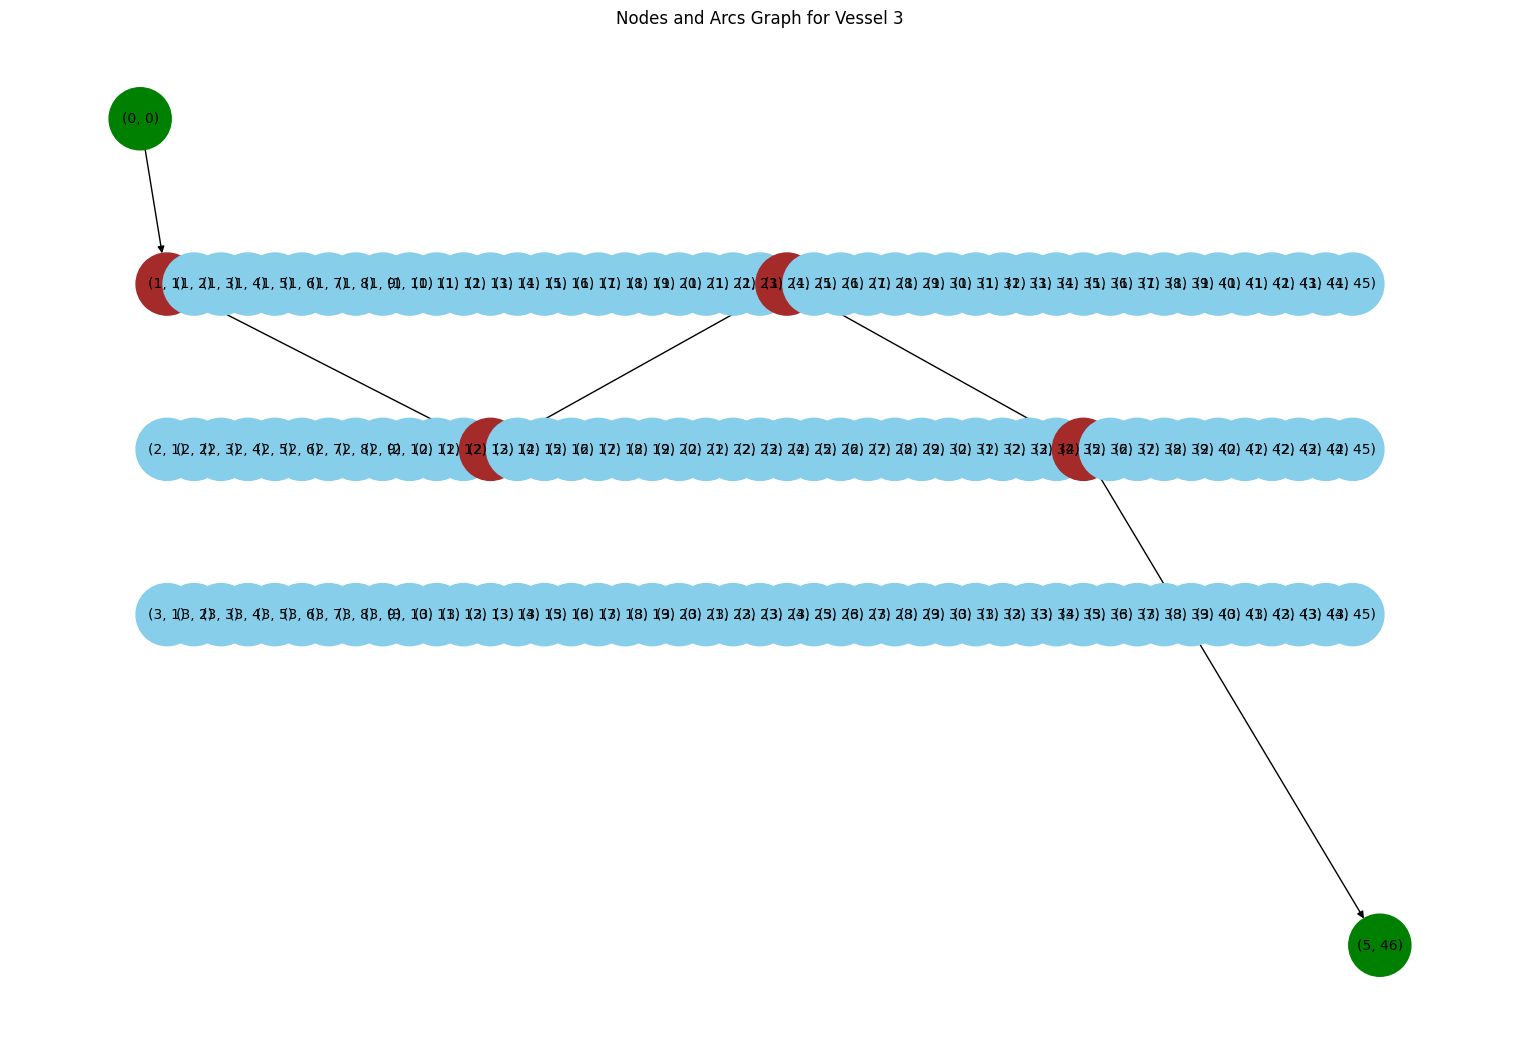

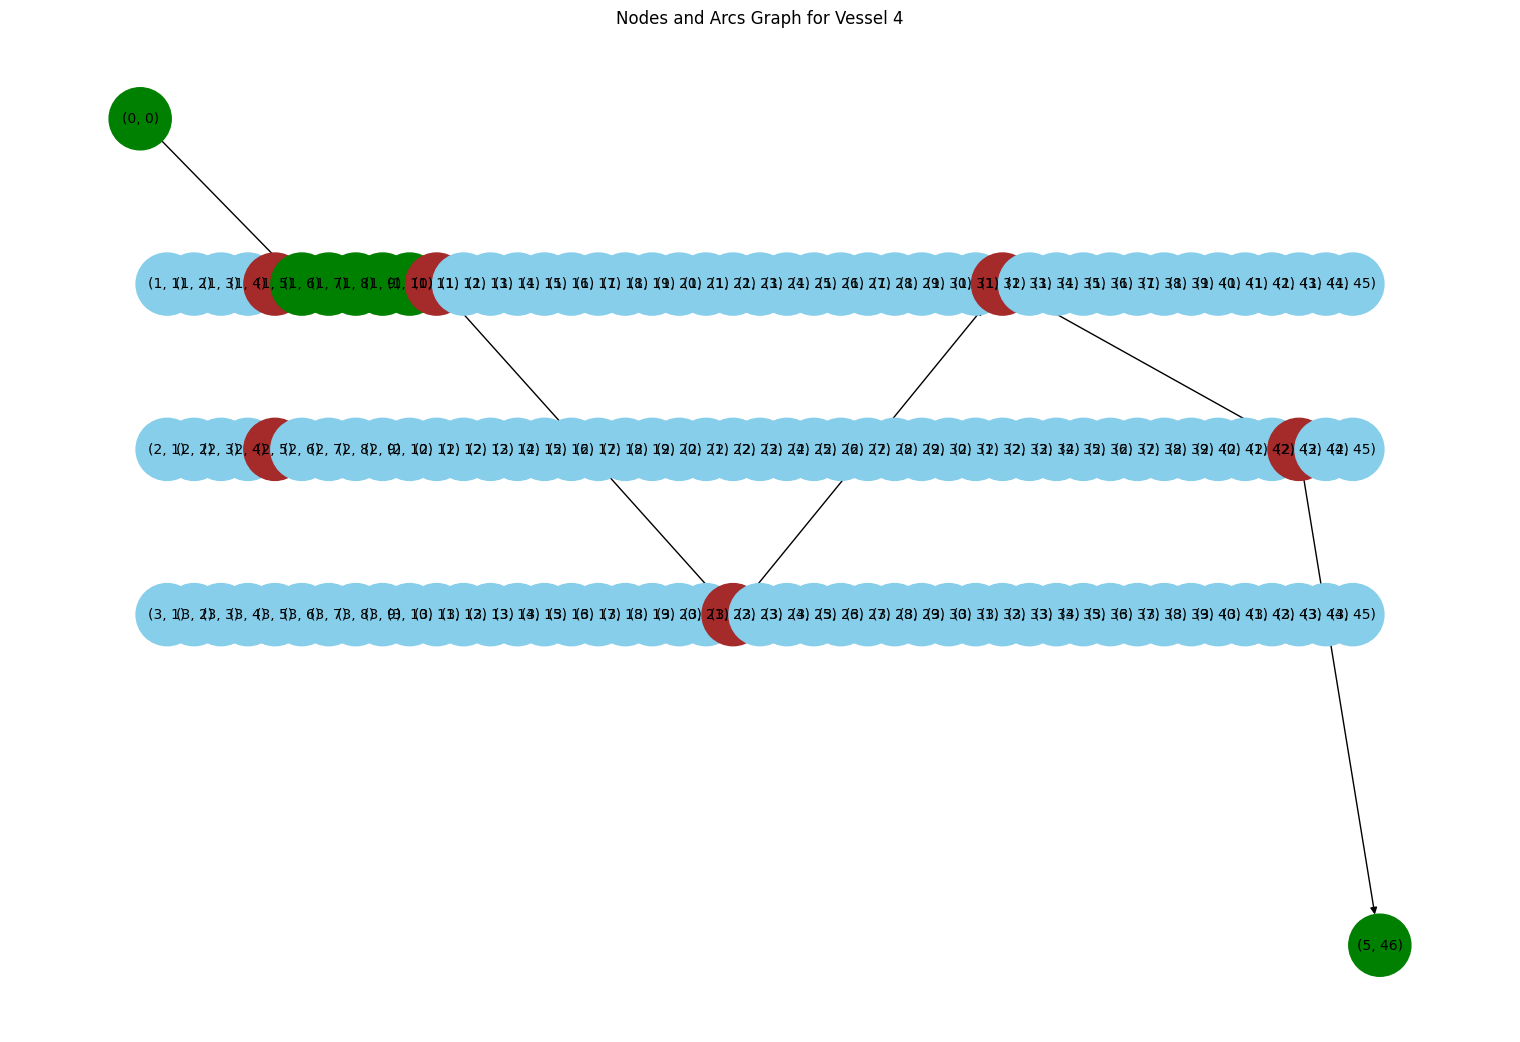

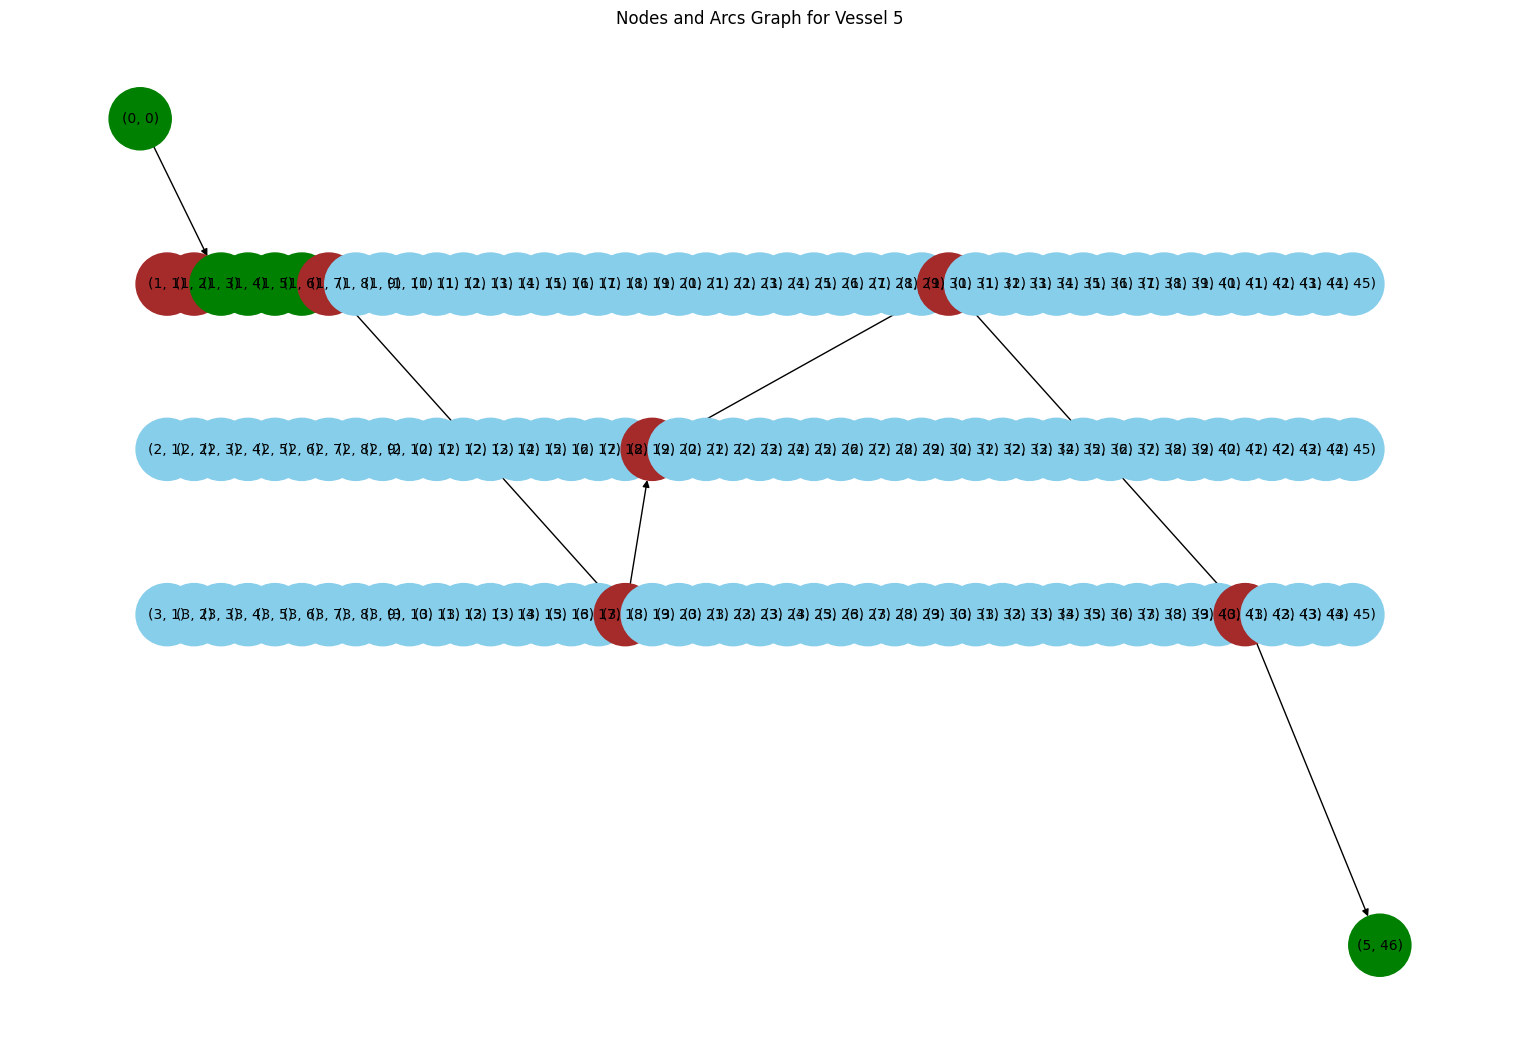

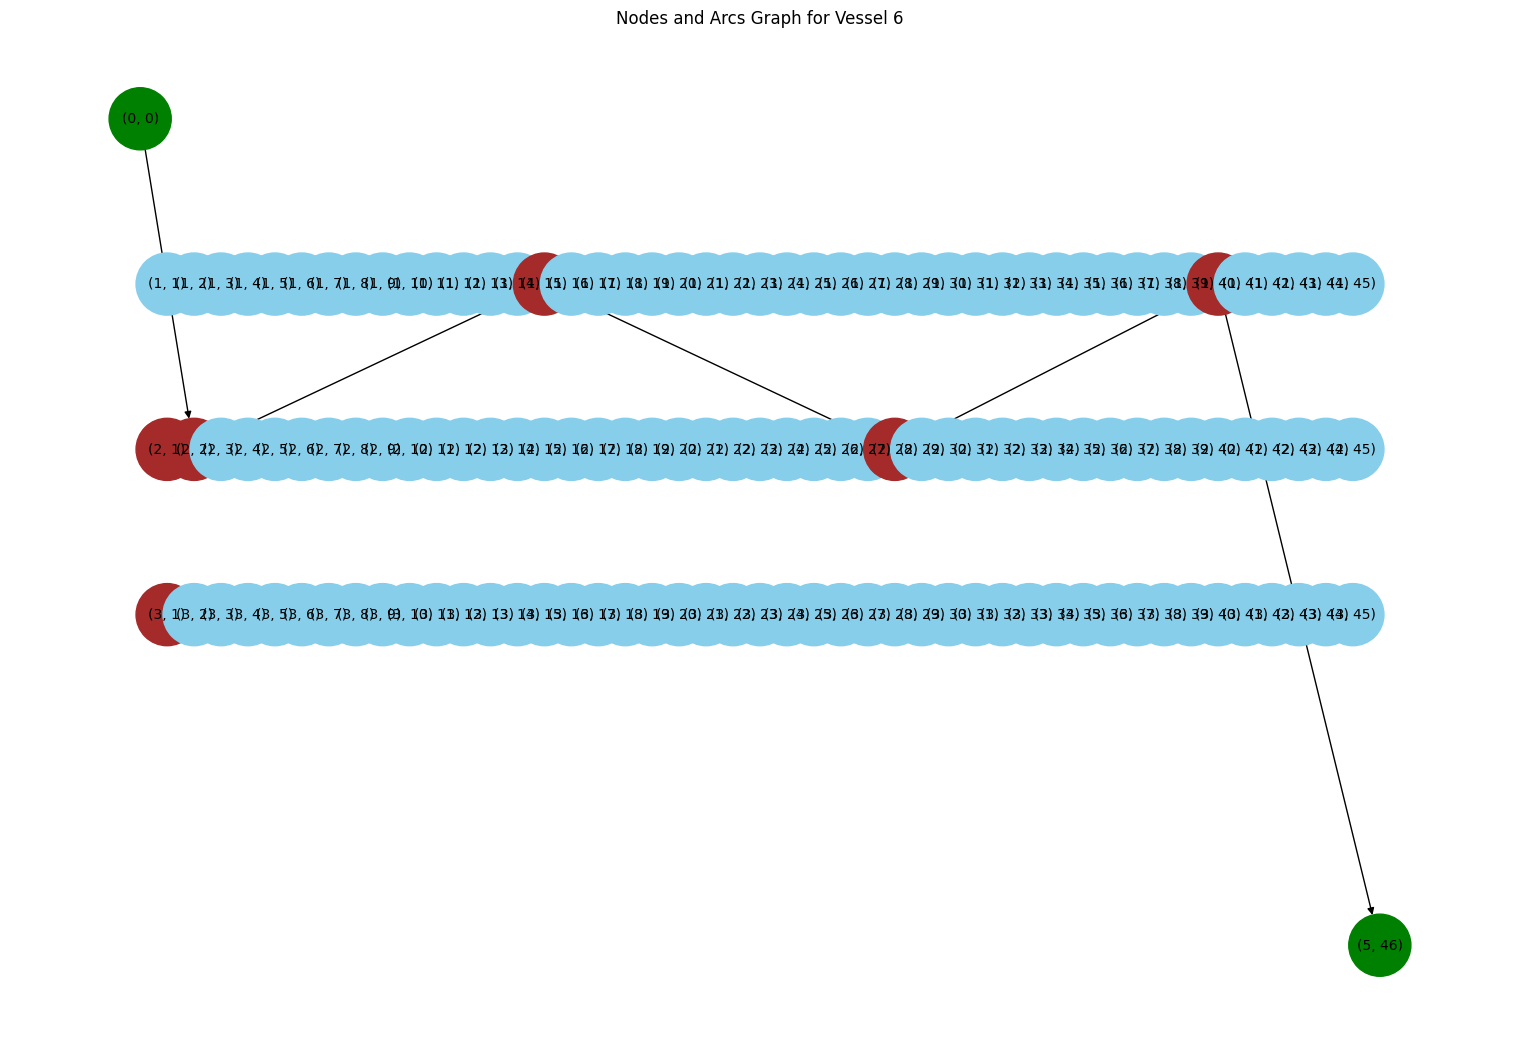

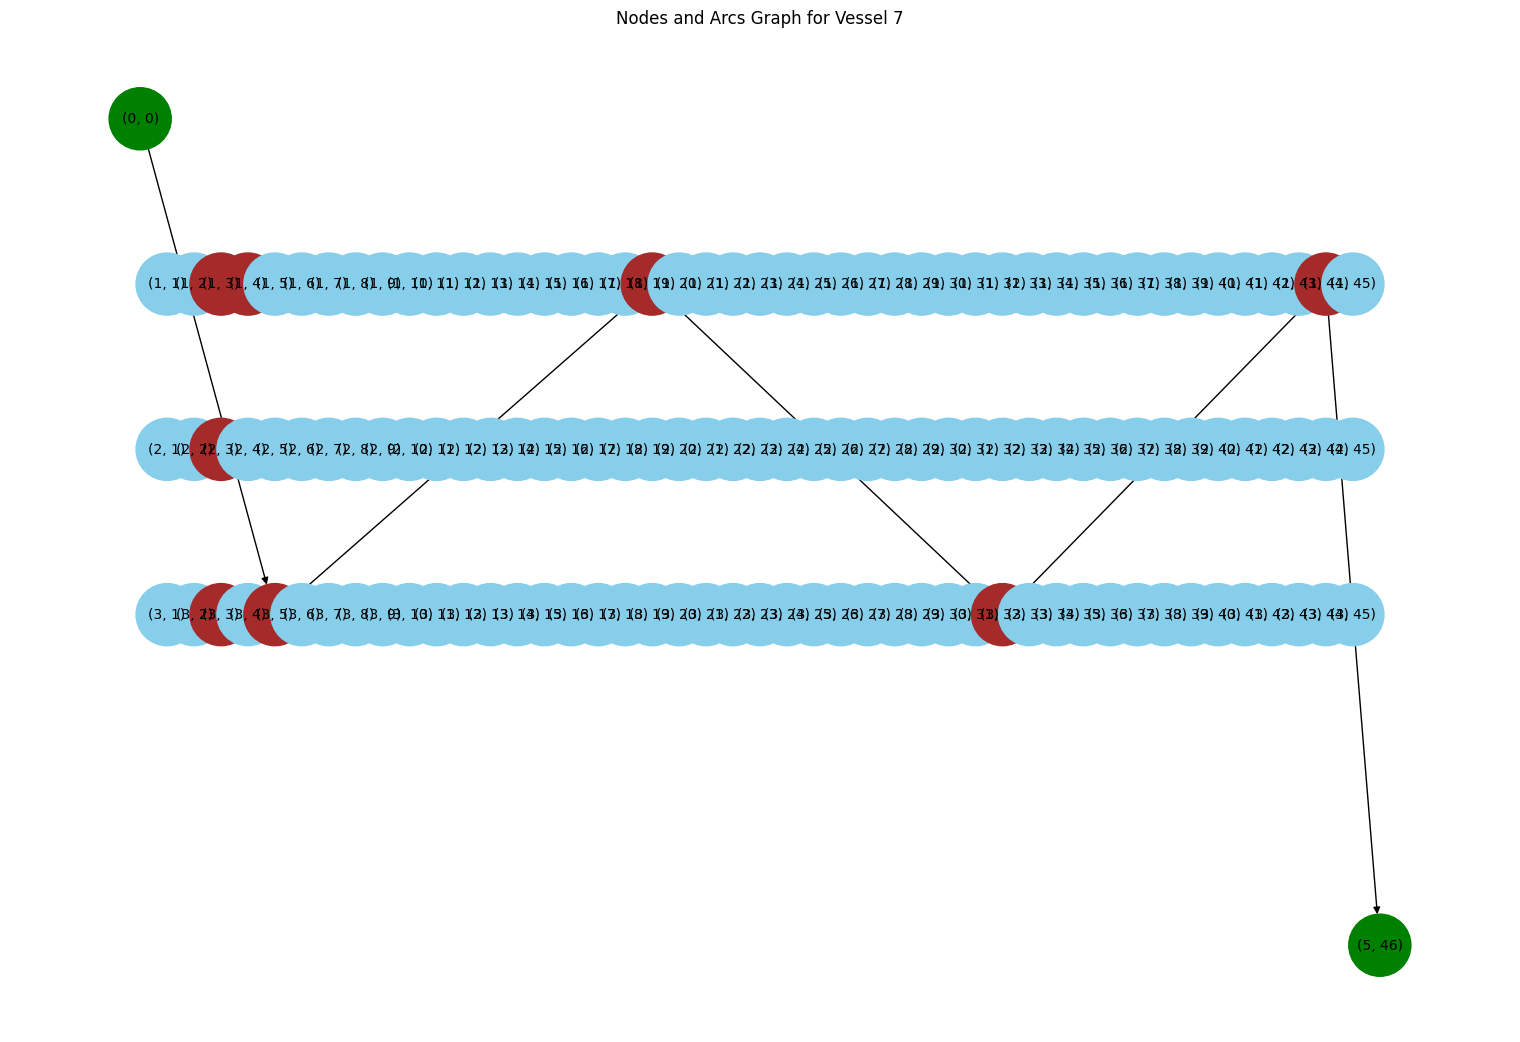

In [126]:
for v in vessels:
    visualize_solution_for_vessel(v, vessel_routes_incl_wa)
    

In [114]:
for v in vessels:
    visualize_network_for_vessel(v, vessel_arcs, True)


In [ ]:
# Print all x-vars that are 1
active_arcs = {}
for v in vessels:
    v_arcs_active = []
    for arc in vessel_arcs[v]:
        if x[arc.tuple, v].x > 0 + EBS:
            v_arcs_active.append(arc)
    active_arcs[v] = v_arcs_active

# LOG

In [ ]:
def log(filepath):
    # Open a file to write the results
    with open(filepath, 'w') as file:
        
        file.write("Hyperparameters:\n")
        file.write(f"Number of Time Periods: {NUM_TIME_PERIODS}\n")
        file.write(f"Time Period Range: {TIME_PERIOD_RANGE}\n")
        file.write(f"Original Number of Vessels: {ORIGINAL_NUM_VESSELS}\n")
        file.write(f"Number of Vessels: {NUM_VESSELS}\n")
        file.write(f"Max Speed: {MAX_SPEED}\n")
        file.write(f"Min Speed: {MIN_SPEED}\n")
        file.write(f"Operating Speed: {OPERATING_SPEED}\n")
        file.write(f"Operating Cost: {OPERATING_COST}\n")
        file.write(f"Waiting Cost: {WAITING_COST}\n")
        file.write(f"Fuel Price (USD/ton): {FUEL_PRICE}\n\n")
        file.write(f"Number of ports: {NUM_PORTS}\n\n")
        
        file.write("\nPorts:\n")
        for port in ports:
            file.write(f"{port.__repr2__()}\n")
            
        file.write("\nVessels:\n")
        for vessel in vessels:
            file.write(f"{vessel.__repr2__()}\n")
        
        file.write("\nFull distance matrix:\n")
        for row in FULL_DISTANCE_MATRIX:
            row_str = ', '.join([f"{item:.4f}" for item in row])  # Format each item in the row
            file.write(f"[{row_str}]\n")
            
        file.write("\n Start times:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {start_times[vessel]}\n")
        file.write("\n")
        
        file.write("----------------------------------------\n")
        # Write the objective value
        file.write(f"Objective Value: {m.objVal}\n")    
        file.write("----------------------------------------\n")
        
        # Log the GAP
        file.write("\nOptimality Gap:\n")
        gap_percentage = m.MIPGap * 100  # Convert to percentage
        file.write(f"Current GAP: {gap_percentage:.2f}%\n")
        
        file.write("\nVessel Routes:\n")
        for vessel, route in vessel_routes_seq.items():
            file.write(f"{vessel}: {route}\n")
            
        # Write the active arcs to file
        file.write("\nActive Arcs:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {[arc for arc in active_arcs[vessel]]}\n")
        file.write("\n")
        
        # Write the all arcs to file
        file.write("\nAll Arcs:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {[arc for arc in vessel_arcs[vessel]]}\n")
        file.write("\n")

        # Write the values of all variables
        file.write("Variable Values:\n")
        for var in m.getVars():
            file.write(f"{var.varName}: {var.x}\n")
            
        file.close()

In [ ]:
if LOG:
    log(FILEPATH)

In [ ]:
LOG

False

In [ ]:
FILEPATH

'new_official_solutions/LR1_2_DR1_3_VC2_V6a/MIRP_RF_SPEED_OPTI_results_LR1_2_DR1_3_VC2_V6a_45_FA.txt'